## Modelling the effects of transcranial alternating current stimulation on the neural encoding of speech in noise

### Implementation of the model introduced in Kegler M. & Reichenbach T. (submitted) *Modelling the effects of transcranial alternating current stimulation on the neural encoding of speech in noise*

The core of the neural network encoding natural speech is mainly based on [Hyafil et al., 2015](https://elifesciences.org/articles/06213.pdf). This notebook is a demo of the network processing a speech utterance and encoding its content through spiking activity. In particular, the slower theta activity parses the utterance into chunks and faster gamma activity captures acoustic content of each chunk. Custom written code is divided into 5 modules:
- **PyNSL** - Direct Python port of parts of NSL toolbox [Chi et al., 2005](https://asa.scitation.org/doi/full/10.1121/1.1945807). The original Matlab implementation is available [here](http://nsl.isr.umd.edu/downloads.html).
- **Network** - Core implementation of the model used in simulations. Includes all the equations and parameters with hard-coded parameter values.
- **Network_utils** - Module containing functions used for preprocessing auditory inputs to the model.
- **Stimulation_utils** - Module containing functions used to extract and preprocess envelope-shaped stimulation waveforms derived from the speech stimulus.
- **Analysis_utils** - Module containing functions used for analysis of model simulations to the extraction features representing syllable encoding in the model simulation.

Each module contains Python functions called in this demo. Large-scale simulations described in the paper were performed using the Imperial College high-performance computing cluster. This demo is illustrating a single simulation of the model and extraction of features later used in the analysis employing different conditions. For the sake of this demo, sample audio tracks of a randomly selected TIMIT sentence & pre-mixed babble noise are available in the SampleAudio directory. Full TIMIT speech corpus used in the paper is available [here](https://catalog.ldc.upenn.edu/LDC93S1).

#### Demo outline
- Loading & preprocessing auditory inputs to the model
- Envelope-shaped stimulation waveform extraction
- Simulation & visualization
- Extraction of features encoded in the simulation

#### Required 3rd party packages
- [SciPy](https://www.scipy.org/)
- [matplotlib](https://matplotlib.org/)
- [SoundFile](https://pysoundfile.readthedocs.io/en/latest/)

For convenience *tACSmodel_env.yml* can be used to set up environment as described [here](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html). The environment and the code were tested on a Linux (Ubuntu 16.04 LTS) and MAC (macOS Catalina 10.15.5) machines.

Author: Mikolaj Kegler (mikolaj.kegler16@imperial.ac.uk)

In case of any issues, questions or suggestions, please do open an issue in the repository and/or email me directly.

Last updated: 4th June 2020

In [1]:
%matplotlib inline

# Thrid party packages
import time
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Custom written code
import Network
import Network_utils as network_tools
import Stimulation_utils as stim_tools
import Analysis_utils as analysis_tools

### Load sample data, mix speech & noise and process the mixture through the auditory periphery model to obtain model input
The above cell implements loading of the sample TIMIT sentence and pre-mixed babble noise. Then the two files are mixed at the designed SNR and processed through the model of auditory periphery implemented in **PyNSL**. The whole process is implemented in *load_TIMIT* routine from **network_utils** module.

75.91740354412542 dB SPL
Audio loaded and processed in 0.19 s
Syllable boundaries: [ 1106.   1635.   4261.   5885.   6400.   7644.5  8600.  10297.5 11475.
 11820.  13683.5 14177.  15415.  17455.  21015. ]
Syllable labels (phonetic trascript.): ['ih', 'G-+-w-aa', 'n-ax-z', 'ae-n-D', 'ae', 'l-ax', 'G-+-ey', 'T-er-z', 'er', 'T-+-r-aa', 'P-+-ih', 'K-+-ax-l', 'r-eh-P', 'T-ay-l-z']


Text(0, 0.5, 'Auditory channels (< 4000 Hz)')

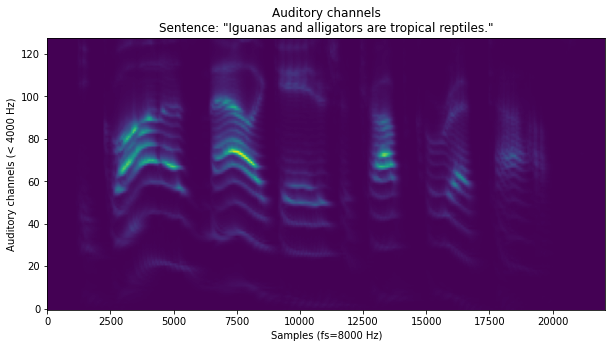

In [2]:
'''
Inputs:
    path_signal - path to the TIMIT sentence. 
    DO NOT include .wav extension, as the script below automatically loads audio file and its phonetic transcription in *_SYL.npy file.

    path_noise: path to the noise interfering with the speech signal. If None, no noise will be added to the speech signal. 
    Simlarly to the above do not include the file extension for consistency.

    mode: mixing mode. What type of mixing will be applied to the audio.
    Avaliable options:
    * clean - no noise will be added and path_noise ignored.
    * babble - noise will be mixed at the desired SNR (variable SNR_dB)
    * deaf - control condition when only background noise (without target speaker) is presented to the network

    SNR_dB: desired SNR of the mixture (in dB). (np.inf is the same 'mode = clean')

    fs: sampling frequency of the output, in Hz

Outputs:
    channels: auditory channels representing input to AC. Obained through the model of audtory periphery (Python port of NSL toolbox (Chi, et al., 2005)).
    
    syl_bounds: syllable boundaries obtained from TIMIT transcriptions (sampling rate - fs). Note: last syllable boundary indicates end of the sentence.
    
    syl_labels: syllable identities. Note: Because of the above, syl_labels will always be one element shorter than syllable bounds.
    
    full_sentence: transcription of the sentence.
'''

path_signal = './SampleAudio/SX95'
path_noise = './SampleAudio/male_babble11'

mode = 'clean' # Mixing mode
SNR_dB = np.inf # SNR
fs=8000 # Sampling rate of the auditory peripher model output

start = time.time()

# Load TIMIT sentence and associated file with syllable onsets/labels, obtain auditory channels and upsample
channels, syl_bounds, syl_labels, full_sentence = network_tools.load_TIMIT(path_signal, path_noise, mode, SNR_dB, fs)

assert((len(syl_bounds) - len(syl_labels)) == 1) # Note last syllable boundary indicates the end of the sentence instead of the onset!!!

end = time.time()

print('Audio loaded and processed in {} s'.format(np.round(end-start,2)))

print('Syllable boundaries: {}'.format(syl_bounds))
print('Syllable labels (phonetic trascript.): {}'.format(syl_labels))

# Simple visualization
plt.figure(figsize=(10,5))
plt.title('Auditory channels\nSentence: "{}"'.format(full_sentence))
plt.imshow(channels.T, aspect='auto', origin='lower left')
plt.xlabel('Samples (fs={} Hz)'.format(fs))
plt.ylabel('Auditory channels (< 4000 Hz)')

### Pre-process data to obtain input to the network
In this cell, the above obtained input will be processed to obtain auditory input to the model. The routine used is *get_network_input* from the **Network_utils** module. The pre-trained STRF kernel (*STRF_kernel.npy*) is used to obtain input to the Te neurons.

Input processed in 0.81 s


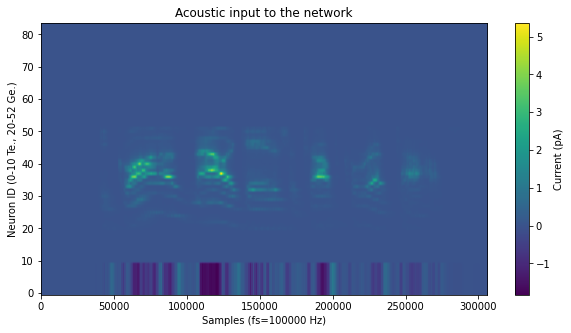

In [3]:
'''
Inputs:
    channels: auditory channels obtained in the previous step.
    syl_bounds: syllable boundaries (sampling rate -> fs) obtained from the previous step
    syl_labels: syllable identities obtained from the previous step.
    fs: sampling frequency of auditory channels obtained earlier.
    fs_up: upsampled sampling rate for simualtions. Default: 100kHz
    Tsil - silence at the beginning and the end of the audio input (in seconds)

Outputs:
    Iext - external current representing auditory input to the 84 neurons in the network.
    dt_sim - simulation timestep (in miliseconds)
'''

start = time.time()

fs_sim = 100000 # Default: 100 kHz. Note, smaller sampling rates of the simulations are not sufficient for faster gamma acitivty.

Tsil=[0.25,0.05] # Silence [before after] sentence (in s)

syl = ((syl_bounds + Tsil[0]*fs - 1)*np.float(fs_sim)/fs).astype(np.int) # Shift syllable boundaries by the amount of silence before the sentence and upsample

# Load the spectrotemporal kernel used to process input to Te cells (i.e. tracking of syllable onsets).
STRF_kernel = np.load('STRF_kernel.npy', allow_pickle=True, encoding='latin1').item()
S = STRF_kernel['W_spec']
T = STRF_kernel['W_temp']

# Filter channels through the kernel & upsample to obtain input to the model (Te & Ge cells)
Iext, dt_sim = network_tools.get_network_input(channels, S, T, fs, fs_sim, Tsil=Tsil)

end = time.time()

print('Input processed in {} s'.format(np.round(end-start,2)))

plt.figure(figsize=(10,5))
plt.title('Acoustic input to the network'.format(full_sentence))
plt.imshow(Iext, aspect='auto', origin='lower left')
plt.xlabel('Samples (fs={} Hz)'.format(fs_sim))
plt.ylabel('Neuron ID (0-10 Te., 20-52 Ge.)')
plt.colorbar(label='Current (pA)')

### Obtain waveform stimulation
The below example presents the extraction and pre-processing of speech-inspired stimulation waveforms. The routine used is *get_envs* from the **Stimulation_utils** module.

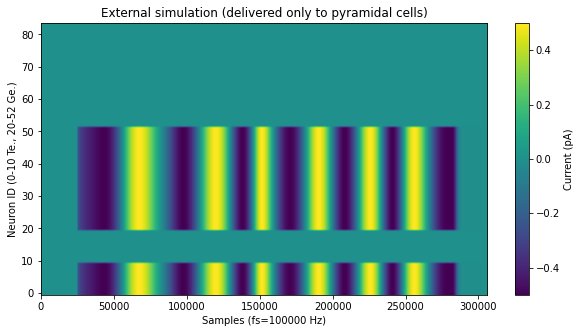

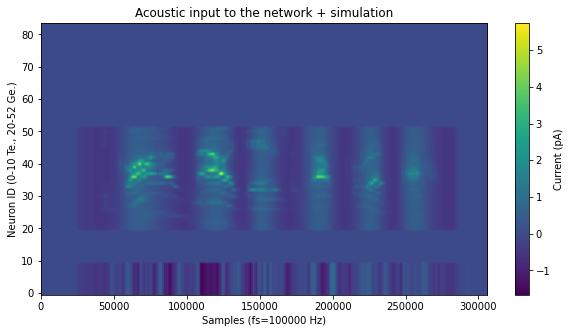

In [4]:
'''
Here we simulate the application of electrical current by injecting addtional input to the pyramidal (excitatory) cells in the network. 
Based on the recent research they are much more susceptible to the stimulation that their inhibitory counterparts.
In this example we are extracting the stimulation wavefrom from the envelope of the example TIMIT sentence, filter it and phase-shift the resulting signal.
'''

### Extract and process the envelope-shaped waveform
### Uncomment the desired envelope processing
Env = stim_tools.get_envs('./SampleAudio/SX95.WAV', [1, 4], fs_out=100000, phases=np.arange(0, 360, 60), saturate=True) # Delta-band waveform
# Env = stim_tools.get_envs('./SampleAudio/SX95.WAV', [4, 8], fs_out=100000, phases=np.arange(0, 360, 60), saturate=True) # Theta-band waveform
# Env = stim_tools.get_envs('./SampleAudio/SX95.WAV', [1, 20], fs_out=100000, phases=np.arange(0, 360, 60), saturate=False) # Broadband waveform

### Note that in the previous steps the silence was added to the acoustic input. Here we will need to compensate for that
Stim_signal = Env['0deg'] # Chosen stimulation waveform. Dictionary key in this case ranges from 0 - 300 deg. Representing phase-shifts.
Onset_sil = np.int(fs_sim*Tsil[0]) # Silence duration in samples
Stim_len = Stim_signal.shape[0] # Stimulation duration in samples
Stim_start = Onset_sil # Onset of the simulation in samples
Stim_end = Onset_sil + Stim_len # Offset of the stimulation in samples

### Choose stimulation intensity. This value indicates max possible current delivered in the network in pA (since the waveforms do not exceed +/- 1).
### Uncomment the desired intensity
# Stim_intensity = 0. # No stimulation
# Stim_intensity = 0.1 # ~ 1 mV depolarization in an isolated neuron
# Stim_intensity = 0.2 # ~ 2 mV depolarization in an isolated neuron
Stim_intensity = 0.5 # ~ 5 mV depolarization in an isolated neuron

Istim = np.zeros(Iext.shape) # Pre-allocate stimulation matrix

Istim[:10, Stim_start:Stim_end] = Stim_intensity*Stim_signal # Apply to Theta excitatory neurons
Istim[20:52, Stim_start:Stim_end] = Stim_intensity*Stim_signal # Apply to Gamma excitatory neurons

Iext = Iext + Istim # Add stimulation to the network input obtained in the previous step (Note: in case of parameter change the above cell needs to be re-run!)

# Simple visualization
if Stim_intensity > 0:
    plt.figure(figsize=(10,5))
    plt.title('External simulation (delivered only to pyramidal cells)'.format(full_sentence))
    plt.imshow(Istim, aspect='auto', origin='lower left')
    plt.xlabel('Samples (fs={} Hz)'.format(fs_sim))
    plt.ylabel('Neuron ID (0-10 Te., 20-52 Ge.)')
    plt.colorbar(label='Current (pA)')

plt.figure(figsize=(10,5))
plt.title('Acoustic input to the network + simulation'.format(full_sentence))
plt.imshow(Iext, aspect='auto', origin='lower left')
plt.xlabel('Samples (fs={} Hz)'.format(fs_sim))
plt.ylabel('Neuron ID (0-10 Te., 20-52 Ge.)')
plt.colorbar(label='Current (pA)')

### Simulation of the network
The below cell calls the simulation function using the above obtained parameters. The routine used is *run* from the **Network** module.

In [5]:
'''
Inputs:
    Tsim - simulation time (ms).
    dt_inp - simulation timestep (ms).
    Iext - External input to the network (84 x N) from the previous cell.

Outputs:
    V - evolution of membrane potential in the network
    spikes - rasterplot of spikes (binary code - big matrix)
    LFP - local field potential of the network
'''

# Approximate runtime (~30 s)
# Approximate RAM consumption (< 6 GB)

start = time.time()
Tsim = int(Iext.shape[1]*dt_sim)
V, spikes, LFP = Network.run(Tsim, dt_sim, Iext.T)
end = time.time()

print ('Done in {} s'.format(np.round(end-start, 3)))

Done in 39.479 s


### Visualization of simulation results

[Text(0, 0, '-0.5'),
 Text(0, 0, '0.0'),
 Text(0, 0, '0.5'),
 Text(0, 0, '1.0'),
 Text(0, 0, '1.5'),
 Text(0, 0, '2.0'),
 Text(0, 0, '2.5'),
 Text(0, 0, '3.0'),
 Text(0, 0, '3.5')]

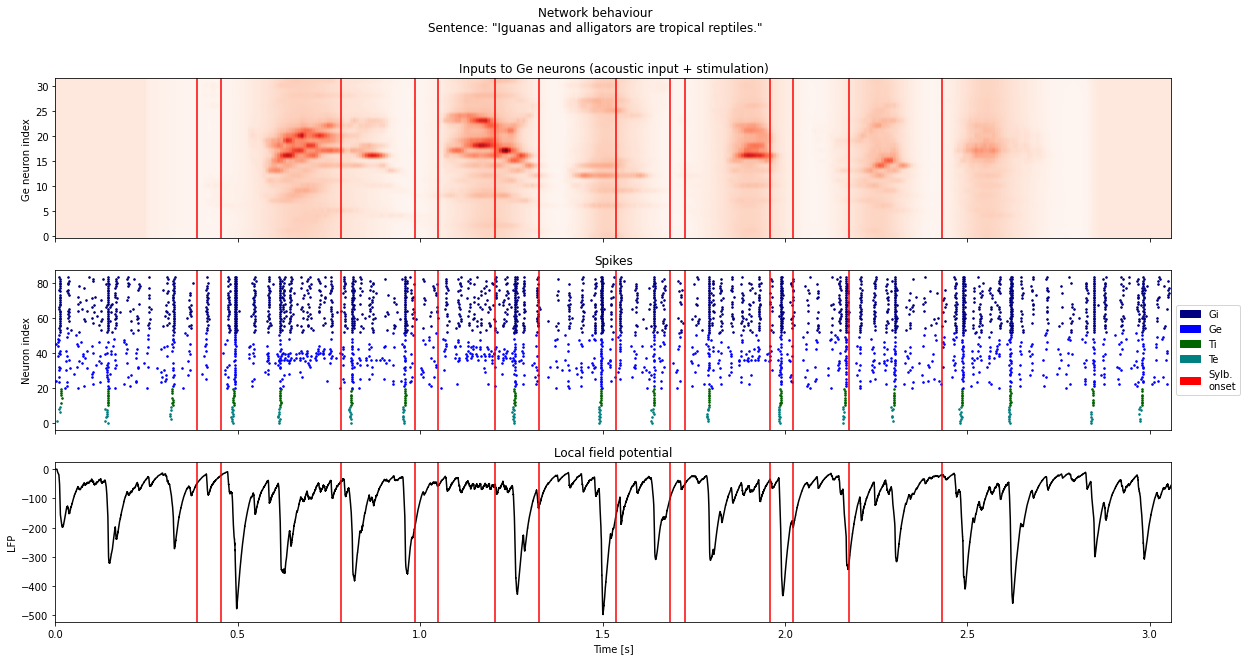

In [6]:
'''
Simple visualization of the model simulation.
'''

f, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(20,10))

f.suptitle('Network behaviour\nSentence: "{}"'.format(full_sentence))

ax3.set_title('Local field potential')
ax3.plot(LFP, 'k')
ax3.set_ylabel('LFP')

marker_size = 2.5

ax2.scatter(np.where(spikes[:,:10]==1)[0], np.where(spikes[:,:10]==1)[1], s=marker_size, color='teal', label='TE')
ax2.scatter(np.where(spikes[:,10:20]==1)[0], np.where(spikes[:,10:20]==1)[1]+10, s=marker_size, color='darkgreen', label='TI')
ax2.scatter(np.where(spikes[:,20:52]==1)[0], np.where(spikes[:,20:52]==1)[1]+20, s=marker_size, color='blue', label='GE')
ax2.scatter(np.where(spikes[:,52:]==1)[0], np.where(spikes[:,52:]==1)[1]+52, s=marker_size, color='navy', label='GI')

legend_elements = [Patch(facecolor=c, edgecolor=c) for c in ['red', 'teal', 'darkgreen','blue','navy'][::-1]]
ax2.legend(legend_elements, [ 'Sylb.\nonset', 'Te', 'Ti', 'Ge', 'Gi',][::-1], loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title('Spikes')
ax2.set_ylabel('Neuron index')

ax1.set_title('Inputs to Ge neurons (acoustic input + stimulation)')
ax1.imshow(Iext, aspect='auto', vmin=-np.max(Iext)/5, vmax=np.max(Iext)/5, cmap='RdBu_r', origin='lower left')
ax1.imshow(Iext[20:52,:], aspect='auto', vmin=np.min(Iext[20:52,:]), cmap='Reds', origin='lower left')
ax1.set_ylabel('Ge neuron index')

[ax1.axvline(i, color='r') for i in syl[:-1]]
[ax2.axvline(i, color='r') for i in syl[:-1]]
[ax3.axvline(i, color='r') for i in syl[:-1]]

ax3.set_xlabel('Time [s]')
ax3.set_xticklabels(ax2.get_xticks()*dt_sim/1000)

Overall, the syllable onsets predictions are not perfect, but slower theta activity clearly aligns to the syllabic rhythm. Notice different 'inter-burst' intervals between the consecutive bursts in the theta module (green). The gamma population is modulated by its slower theta counterpart through the unidirectional cross-frequency coupling. The excitatory neurons (light blue) receive tonotopically-organized inputs presented in the top panel and encode acoustic content of the syllables parsed via theta network.

### Detections of syllable boundaries and chunking of Ge neural code
Routines for the analysis of the model simulations in order to extract encoded features are included in the **Analysis_utils** module.

Text(0.5, 0.98, 'Sentence: "Iguanas and alligators are tropical reptiles."\n Pairwise spike distance matrices of 14 subsequent syllables identified and encoded by the network')

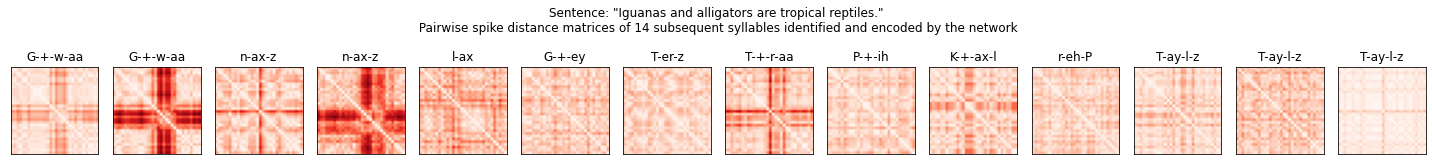

In [7]:
'''
This is an example of how we can obtain features from the network encoding for subsequent analysis.
The rough idea is to:
1. Obtain the predicted syllable onsets from the bursts of Theta spikes.
2. Obtain chunks of gamma spike code (Ge neurons) representing syllable content.
3. Extract pairwise spike distance features from each chunk corresponding to a syllable detected and encoded by the network.
'''

### Obtain theta network preductions about the onsets of syllables
detected = analysis_tools.burst_detector(spikes[:,10:20], dt_sim, 20)

### Obtain gamma spike code from between theta bursts (syllable content)
start = time.time()
th_chunks, th_chunks_labels = analysis_tools.get_chunks(detected, syl, syl_labels, dt_sim)
th_chunks = th_chunks.astype(np.int)

assert(th_chunks.shape[0] == len(th_chunks_labels))

### Extract features describing syllable identity through: 
VPd = np.zeros((th_chunks.shape[0], 32, 32))
sts = []

cost = 60

# Obtain spike times from binary representaion of spike trains in each chunk
sts = [np.array(np.where(spikes[th_chunks[i, 0]:th_chunks[i, 1], 20:52] == 1)) for i in range(th_chunks.shape[0])]

# Compute pairwise spike distance for each encoded chunk of neural data representing a syllable
VPd = np.array([analysis_tools.get_selfdist(s, 32, cost, dt_sim) for s in sts])

### Simple visualization of features from the encoded syllables.
f, ax = plt.subplots(1,VPd.shape[0], figsize=(20,3), sharex=True)

for i in range(len(ax)):
    ax[i].imshow(VPd[i,:,:], cmap='Reds', vmax=np.max(VPd))
    ax[i].set_title('{}'.format(th_chunks_labels[i]))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
f.tight_layout()
f.suptitle('Sentence: "{}"\n Pairwise spike distance matrices of {} subsequent syllables identified and encoded by the network'.format(full_sentence, VPd.shape[0]))

The above presented simulation and the feature extraction of encoded sentences were used in the paper, as they are presented here. The results of many simulations were used to quantify parsing scores by comparing predicted syllable onsets to the actual onsets from TIMIT transcriptions. In turn, the decoding of syllable identities was performed using the above-presented pairwise distance matrices. The influence of different types of tACS was investigated by comparing how the two metrics changes across simulations of many different sentence at different SNRs.